# How to create Figure 2


**Paper:** https://arxiv.org/pdf/2002.09301.pdf



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from difflikelihoods import odesolver
from difflikelihoods import linearised_odesolver as linsolver
from difflikelihoods import linearised_ode as linode
from difflikelihoods import statespace
from difflikelihoods import inverseproblem as ip

from difflikelihoods.sampling import metropolishastings_pham, metropolishastings_plang, metropolishastings_rw


from difflikelihoods.optimisation import minimise_newton, minimise_gd, minimise_rs


The `create_data()` function is slightly different for each experiment, so we specify it first.

In [2]:
def create_data(solver, ivp, thetatrue, stepsize, ivpvar):
    """
    Create artificial data for the inverse problem.
    """
    ivp.params = thetatrue
    tsteps, m, __, __, __ = solver.solve(ivp, stepsize)
    means = odesolver.get_trajectory_ddim(m, 2, 0)
    evalpts = np.array([1., 2., 3., 4., 5., 6., 7., 8., 9.])
    assert(np.prod(np.in1d(evalpts, tsteps))==1), print(evalpts[np.in1d(evalpts, tsteps)==False])
    evalidcs = [list(tsteps).index(evalpt) for evalpt in evalpts]
    data = np.array([means[evalidx] + np.sqrt(ivpvar)*np.random.randn()
                     for evalidx in evalidcs])
    ipdata = ip.InvProblemData(evalpts, data, ivpvar)
    return ipdata


Next we define the model parameters. Each of `iplklhd` is a different likelihood associated with either the uncertainty-aware likelihood or not.

In [3]:
# Set Model Parameters
initial_value = np.array([20, 20])
initial_time, end_time = 0., 10.
ivpvar = 1e-3
thetatrue = np.array([0.5, 0.05, 0.05, 0.5])
ivp = linode.LotkaVolterra(initial_time, end_time, params=thetatrue, initval=initial_value)

# Set Method Parameters
h_for_data = (end_time - initial_time)/1000
h1 = (end_time - initial_time)/50
h2 = (end_time - initial_time)/400
h3 = (end_time - initial_time)/100
solver = linsolver.LinearisedODESolver(statespace.IBM(q=1, dim=2))
ipdata = create_data(solver, ivp, thetatrue, h_for_data, ivpvar)
iplklhd = ip.InvProblemLklhd(ipdata, ivp, solver, h1, with_jacob=True)
iplklhd2 = ip.InvProblemLklhdClassic(ipdata, ivp, solver, h1, with_jacob=True)
iplklhd3 = ip.InvProblemLklhd(ipdata, ivp, solver, h2, with_jacob=True)
iplklhd4 = ip.InvProblemLklhdClassic(ipdata, ivp, solver, h2, with_jacob=True)

Now we compute the likelihood values on a grid.**This might take a few minutes**.

In [4]:
delta = 0.00125
xpts = np.arange(0.48, 0.52, delta)
ypts = np.arange(0.048, 0.052, 0.1*delta)
X, Y = np.meshgrid(xpts, ypts)
lklgrid1 = np.zeros(X.shape)
lklgrid2 = np.zeros(X.shape)
lklgrid3 = np.zeros(X.shape)
lklgrid4 = np.zeros(X.shape)

for i in range(len(X)):
    for j in range(len(X.T)):
        this_theta = np.array([X[i, j], Y[i, j], 0.05, 0.5])
        lklgrid1[i, j] = (-iplklhd.potenteval(this_theta))
        lklgrid2[i, j] = (-iplklhd2.potenteval(this_theta))
        lklgrid3[i, j] = (-iplklhd3.potenteval(this_theta))
        lklgrid4[i, j] = (-iplklhd4.potenteval(this_theta))


In [5]:
# Only for 'nice' visuals (exp(-40) is way below machine precision).
lklgrid1[lklgrid1 < -40] = -40
lklgrid2[lklgrid2 < -40] = -40
lklgrid3[lklgrid3 < -40] = -40
lklgrid4[lklgrid4 < -40] = -40


Finally, we can plot the level sets for each respective problem.

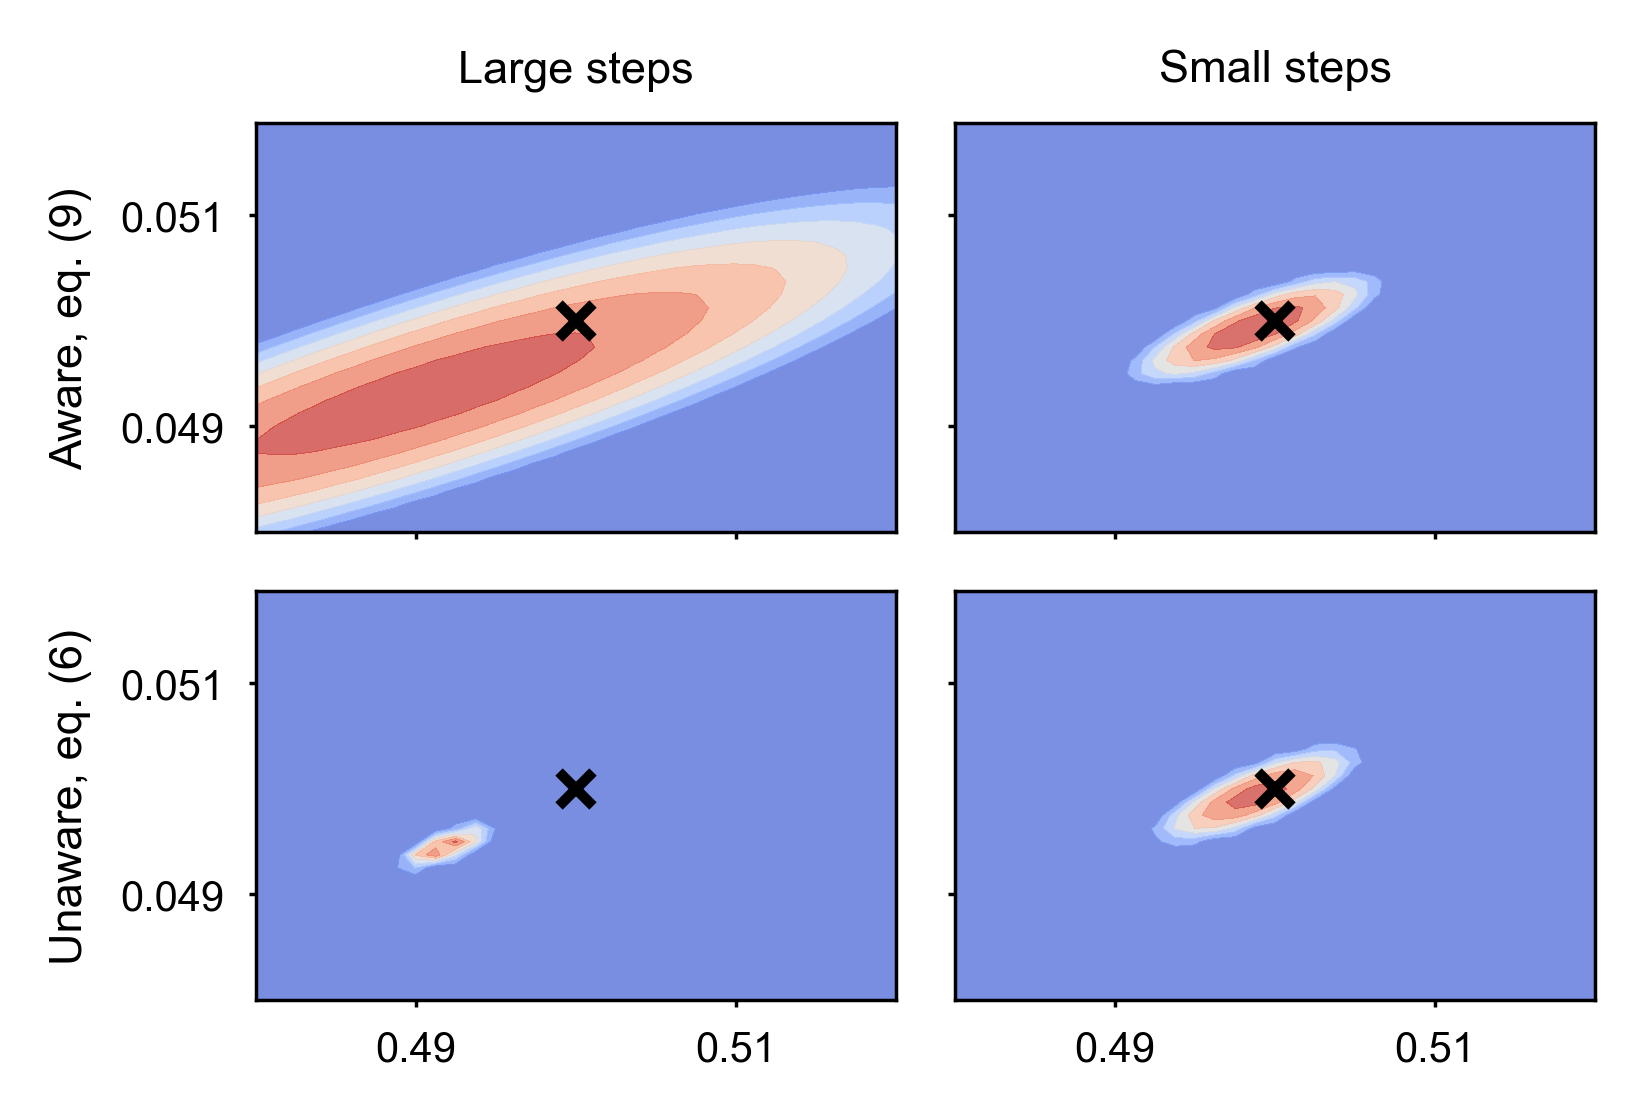

In [8]:

plt.style.use("./icmlstyle.mplstyle")

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(3.3, 2.25))

colormap = 'coolwarm'
_alpha = 0.75

ax[0][0].set_title("Large steps", fontsize=6.5)
ax[0][0].set_ylabel("Aware, eq. (9)", fontsize=6.5)
ax[0][0].contourf(X, Y, (lklgrid1), cmap=colormap, alpha=_alpha)
ax[0][0].plot(thetatrue[0], thetatrue[1], marker='x', markersize=5, mew=1.5, color='black', zorder=2)
ax[0][0].grid(False)


ax[0][1].set_title("Small steps", fontsize=6.5)
ax[0][1].contourf(X, Y, lklgrid3, cmap=colormap, alpha=_alpha)
ax[0][1].plot(thetatrue[0], thetatrue[1], marker='x', markersize=5, mew=1.5,color='black', zorder=2)
ax[0][1].grid(False)



ax[1][0].set_ylabel("Unaware, eq. (6)", fontsize=6.5)
ax[1][0].contourf(X, Y, lklgrid2, cmap=colormap, alpha=_alpha)
ax[1][0].plot(thetatrue[0], thetatrue[1], marker='x', markersize=5, mew=1.5,color='black', zorder=2)
ax[1][0].grid(False)

ax[1][1].contourf(X, Y, lklgrid4, cmap=colormap, alpha=_alpha)
ax[1][1].plot(thetatrue[0], thetatrue[1], marker='x', markersize=5, mew=1.5, color='black', zorder=2)
ax[1][1].grid(False)


for ax_ in ax.flatten():
    ax_.spines["top"].set_visible(True)    
    ax_.spines["right"].set_visible(True)    
    ax_.spines["bottom"].set_visible(True)    
    ax_.spines["left"].set_visible(True)    


plt.xticks([0.49, 0.51])
plt.yticks([0.049, 0.051])
plt.tight_layout()
plt.savefig("./figures/figure2_contours.pdf")

plt.show()